## Sentiment Analysis of Amazon product reviews

We use the preprocessed and clean amazon product reviews dataset from https://www.cs.jhu.edu/~mdredze/datasets/sentiment/.

The dataset consists of 4 datasets containing amazon product reviews on different domains of products - books, dvd, electronics and kitchen.

Each domain's dataset is split into:

1) pre-training set (D_pt) with 100 data samples,

2) training set (D_train) with 1500 data samples,

3) validation set (D_val) with 200 data samples, and

4) test set (D_test) with 200 data samples.

Each dataset split has an equal number of positive and negative reviews in it.

The training procedure is as follows:

> 1) The pre-training set is used to perform preliminary data exploration, and to decide on some candidate models that might be suitable for this dataset. This is done on a small pre-training set, and then it is discarded. This is to ensure that data snooping and bias is avoided. 

> 2) Once we have our candidate models, we perform multi-fold cross validation on the training set to pick the best model. **Important: Once we look at the training set, we cannot change the candidate models that we decided on, because that results in data snooping, overfitting and reduced generalization capability [1].** The model with the lowest CV error will be picked as the best model.

> 3) The best model is then used to predict on the validation set, and the predicted labels are compared with the true labels to get the validation error $E_{val}$, which is an estimate of the out-of-sample error. $E_{val}$ can then be used to bound the TRUE out-of-sample error with the generalization bound [2]. This generalization bound gives us an estimate of how well the model might do on unseen data, accounting for all the bias and overfitting we may have incurred during the training process.

> 4) To test if our model actually obeys the generalization bound, we deploy the model on the test set and obtain the test error $E_{test}$. We expect $E_{test}$ to satisfy the generalization bound we calculated in 3). If it does, model training was successful and we can expect this model to perform reliably with the same performance on unseen data.

We have to do the above procedure for each domain's dataset - books, dvd, electronics, kitchen.

## Get imports and define constants

In [1]:
# imports

import tarfile
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from matplotlib.pyplot import figure
import matplotlib
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
import pickle

In [2]:
# constants (NEVER CHANGE)

RANDOM_SEED = 1
PT_SIZE = 100
TRAIN_SIZE = 1500
VAL_SIZE = 200
TEST_SIZE = 200

## All function definitions

In [ ]:
# Loads the appropriate (positive/negative) data samples from filepath
def load_dataset(domain_name, label_type):
    path = "processed_acl/" + domain_name + "/" + label_type + ".review"
    with open(path) as f:
        file = f.readlines()
    f.close()
    return file

# A function to split a domain's dataset into D_pt, D_train, D_val and D_test
def split_data(pos, neg):
    
    pos_size = len(pos)
    neg_size = len(neg)
    
    D_pt = pos[0:int(PT_SIZE/2)] + neg[0:int(PT_SIZE/2)]
    D_train = pos[int(PT_SIZE/2):int(PT_SIZE/2)+int(TRAIN_SIZE/2)] + neg[int(PT_SIZE/2):int(PT_SIZE/2)+int(TRAIN_SIZE/2)]
    D_val = pos[int(PT_SIZE/2)+int(TRAIN_SIZE/2):int(PT_SIZE/2)+int(TRAIN_SIZE/2)+int(VAL_SIZE/2)] + neg[int(PT_SIZE/2)+int(TRAIN_SIZE/2):int(PT_SIZE/2)+int(TRAIN_SIZE/2)+int(VAL_SIZE/2)]
    D_test = pos[int(PT_SIZE/2)+int(TRAIN_SIZE/2)+int(VAL_SIZE/2):] + neg[int(PT_SIZE/2)+int(TRAIN_SIZE/2)+int(VAL_SIZE/2):]
    
    return D_pt, D_train, D_val, D_test

# Gets a complete list of words used in the reviews
# The reviews in this dataset have already been processed so the corpus will contain 1_gram and 2_gram words
def get_corpus(reviews):
    corpus = []
    for item in reviews:
        review = item.split(" ")
        review = review[0:-1]
        new_review = ""
        for m in np.arange(0, len(review)):
            entry = review[m].split(":")
            for n in np.arange(0,int(entry[1])):
                new_review = new_review + " " + entry[0]
        corpus.append(new_review)
    return corpus

# Gets the label of all the reviews in the input
# In this dataset, the label is at the end of each review, which this functions extracts and returns as a list
def get_labels(reviews):
    labels = []
    for item in reviews:
        label = item.split(" ")[-1].split(":")[1]
        if label==("positive\n"):
            labels.append(1)
        elif label==("negative\n"):
            labels.append(0)
        else:
            print("ERROR: UNDEFINED VALUE\n")
    return labels

# This function splits the dataset into n_splits (to make it ready for multi-fold cross validation)
def stratified_split(dataset, n_splits):

    pos_idx = np.array(get_labels(dataset))==1
    pos_idx = [i for i, x in enumerate(pos_idx) if x]
    neg_idx = np.array(get_labels(dataset))==0
    neg_idx = [i for i, x in enumerate(neg_idx) if x]

    np.random.seed(RANDOM_SEED)
    pos_list = np.random.choice(pos_idx,size=len(pos_idx),replace=False).tolist()
    splits1 = np.array_split(pos_list, n_splits)

    neg_list = np.random.choice(neg_idx,size=len(pos_idx),replace=False).tolist()
    splits2 = np.array_split(neg_list, n_splits)
    
    cv_idx = []
    for n in np.arange(0,len(splits1)):
        cv_idx.append(np.append(splits1[n],splits2[n]))
    
    return cv_idx

# Returns the features extracted by the given trained feature extractor (tfidf or vectorizer) and target labels
def get_Xy(dataset, trained_feature_extractor):
    X = np.array(trained_feature_extractor.transform(get_corpus(dataset)).todense())
    y = np.array(get_labels(dataset))
    return X, y

# Returns the positive and negative reviews in the dataset separately
def get_pos_neg(dataset):
    pos_idx = [i for i, e in enumerate(get_labels(dataset)) if e != 0]
    neg_idx = [i for i, e in enumerate(get_labels(dataset)) if e == 0]
    pos = []
    neg = []
    for i in pos_idx:
        pos.append(dataset[i])
    for j in neg_idx:
        neg.append(dataset[j])
    return pos, neg

# Discriminative feature selection method:
# Function chooses the top m words that frequently occur in positive reviews OR negative reviews, but not both.
# This improves the discriminative capability of the feature set. 
def get_vocab(dataset,half_of_max_features):
    pos, neg = get_pos_neg(dataset)
    stop_list = []
    done = False;
    while (not done):
        fe1 = TfidfVectorizer(max_features=half_of_max_features,stop_words=stop_list)
        fe2 = TfidfVectorizer(max_features=half_of_max_features,stop_words=stop_list)
        fe1 = fe1.fit(get_corpus(pos))
        pos_dict = fe1.vocabulary_
        fe2 = fe2.fit(get_corpus(neg))
        neg_dict = fe2.vocabulary_
        list1 = list(pos_dict.keys())
        list2 = list(neg_dict.keys())
        vocab = list1+list2
        list3 = set(list1)&set(list2)
        stop_list += (sorted(list3, key = lambda k : list1.index(k)))
        done = (len(set(vocab))==len(vocab))
    return vocab

# Performs multi-fold cross validation and returns E_val and variance of the error
def get_cv_error(dataset, feature_extractor, model, n_trials):
    
    avg_cv_error = 0
    for trial in np.arange(0,n_trials):
        
        errors = []
        cv_error = 0
        cv_idx = stratified_split(dataset, 5)
        for n in np.arange(0,len(cv_idx)):

            val = []
            train = []

            val_idx = cv_idx[n]
            for idx in val_idx:
                val.append(dataset[idx])

            l = list(range(0,len(cv_idx)))
            train_idx = [x for x in l if x != n]
            for num in train_idx:
                for idx in list(cv_idx[num]):
                    train.append(dataset[idx])
            
            vocab = get_vocab(train, 500)
            feature_extractor.vocabulary = vocab
            
            labels = get_labels(train)
            y_train = np.array(labels)

            corpus = get_corpus(train)
            X_train = np.array(feature_extractor.fit_transform(corpus).todense())

            clf = model.fit(X_train, y_train)
            X_test = np.array(feature_extractor.transform(get_corpus(val)).todense())
            pred_out = clf.predict(X_test)

            labels = get_labels(val)
            true_out = np.array(labels)
            
            err = ((np.sum(pred_out!=true_out)/len(true_out)))
            errors.append(err)
            cv_error += err/len(cv_idx)

        avg_cv_error += cv_error/n_trials
        var_err = np.var(np.array(errors))

    return avg_cv_error*100, var_err

# Performs multi-fold cross validation on all the candidate models and prints out each model's score and variance
def try_models_on(dataset,domain_name,num_indep_cv_loops):

    print("DOMAIN:", domain_name, "\n")
    
    print("Trying Model 1: Count Vectorizer & Logistic Regression, ", end = '')
    model1_error, model1_var = get_cv_error(dataset, CountVectorizer(), LogisticRegression(), num_indep_cv_loops)
    print("SCORE = " + str(round(100-model1_error,2)) + "%\n")
    
    print("Trying Model 2: TFIDF Vectorizer & Logistic Regression, ", end = '')
    model2_error, model2_var = get_cv_error(dataset, TfidfVectorizer(), LogisticRegression(), num_indep_cv_loops)
    print("SCORE = " + str(round(100-model2_error,2)) + "%\n")
    
    print("Trying Model 3: Count Vectorizer & Linear SVM, ", end = '')
    model3_error, model3_var = get_cv_error(dataset, CountVectorizer(), SGDClassifier(), num_indep_cv_loops)
    print("SCORE = " + str(round(100-model3_error,2)) + "%\n")
    
    print("Trying Model 4: TFIDF Vectorizer & Linear SVM, ", end = '')
    model4_error, model4_var = get_cv_error(dataset, TfidfVectorizer(), SGDClassifier(), num_indep_cv_loops)
    print("SCORE = " + str(round(100-model4_error,2)) + "%\n")
    
    print("Trying Model 5: Count Vectorizer & Gaussian NB, ", end = '')
    model5_error, model5_var = get_cv_error(dataset, CountVectorizer(), GaussianNB(), num_indep_cv_loops)
    print("SCORE = " + str(round(100-model5_error,2)) + "%\n")
    
    print("Trying Model 6: TFIDF Vectorizer & Gaussian NB, ", end = '')
    model6_error, model6_var = get_cv_error(dataset, TfidfVectorizer(), GaussianNB(), num_indep_cv_loops)
    print("SCORE = " + str(round(100-model6_error,2)) + "%\n")
    
    print("Trying Model 7: Count Vectorizer & SGD (Huber Loss), ", end = '')
    model7_error, model7_var = get_cv_error(dataset, CountVectorizer(), SGDClassifier(loss="huber"), num_indep_cv_loops)
    print("SCORE = " + str(round(100-model7_error,2)) + "%\n")
    
    print("Trying Model 8: TFIDF Vectorizer & SGD (Huber Loss), ", end = '')
    model8_error, model8_var = get_cv_error(dataset, TfidfVectorizer(), SGDClassifier(loss="huber"), num_indep_cv_loops)
    print("SCORE = " + str(round(100-model8_error,2)) + "%\n")
    
    score_vec = 100-np.array([model1_error, model2_error, model3_error, model4_error, model5_error, model6_error, model7_error, model8_error])
    loc = np.argmax(score_vec)
    print("Optimal model was Model", loc+1)
    
    variances = [model1_var, model2_var, model3_var, model4_var, model5_var, model6_var, model7_var, model8_var]
    
    return score_vec, variances

## Load data and split into D_pt, D_train, D_val and D_test for each domain's dataset

Splits dataset in each domain into pre-training (100), training (1500), validation (200) and testing (200) datasets. Each dataset has equal number of positive and negative class.

In [4]:
book_pos = load_dataset("books","positive")
book_neg = load_dataset("books","negative")
dvd_pos = load_dataset("dvd","positive")
dvd_neg = load_dataset("dvd","negative")
elec_pos = load_dataset("electronics","positive")
elec_neg = load_dataset("electronics","negative")
kit_pos = load_dataset("kitchen","positive")
kit_neg = load_dataset("kitchen","negative")

books_D_pt, books_D_train, books_D_val, books_D_test = split_data(book_pos, book_neg)
dvd_D_pt, dvd_D_train, dvd_D_val, dvd_D_test = split_data(dvd_pos, dvd_neg)
elec_D_pt, elec_D_train, elec_D_val, elec_D_test = split_data(elec_pos, elec_neg)
kit_D_pt, kit_D_train, kit_D_val, kit_D_test = split_data(kit_pos, kit_neg)

#### What the corpus of the positive reviews in the books domain looks like:

In [5]:
get_corpus(book_pos)

[' holes must top_secret he center other_civilans the_pacific the_navy a_lot surface_must this_book man_named <num>_feet <num>_feet would_strongly put_down norman_johnson lawes a_top the_support ten on_random typhoon a_phycologist pressure actually_an a_day johnson_is strange civilans_to explored support pacific_ocean pressure_to back_some read however_on it_still stuck a_remote american find_out not_have other_crichton analysis.i black_holes after_a misssion some_strange half_mile <num>_navy actually remote_location the_story behavior civilans civilans research_that michael_crichton excellant_novel strongly_recommend some some michael does_not strange_things sphere_by a_man are_joined mile_long put operations spacecraft spacecraft around joined an_american sea a_half pacific the_civilans information_on day_under half that_some lot around_a travels ten_is excellant however novels novels novels find brought random one the_ocean the_ocean the_ocean team a_typhoon read_the all_of feet_und

## Do preliminary data exploration with D_pt in each domain's dataset

### Word clouds of positive (white background) and negative (black background) reviews:

### Domain: books

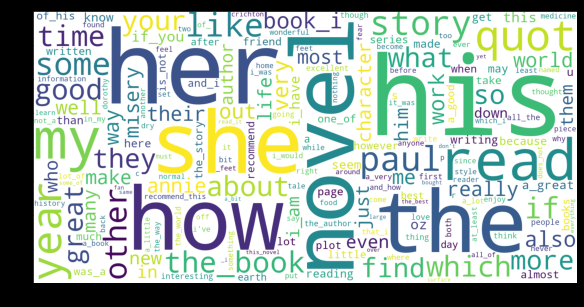

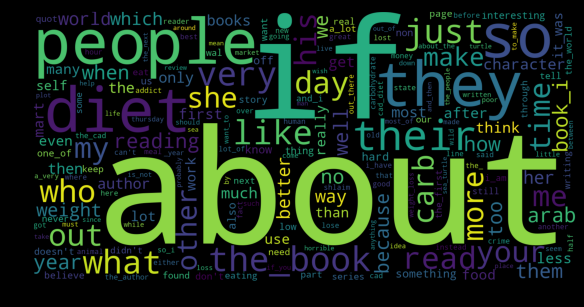

In [6]:
pos_vocab_books_pt = get_corpus(books_D_pt[0:50])
neg_vocab_books_pt = get_corpus(books_D_pt[50:])
stopwords = set(["num","i","book","you","was","not","this_book","he","one","all"])
wordcloud = WordCloud(collocations=False, background_color="white",width=1600, height=800, stopwords=stopwords)
wordcloud.generate(' '.join(pos_vocab_books_pt))
plt.figure( figsize=(10,5), facecolor='k')
plt.imshow(wordcloud)
wordcloud = WordCloud(collocations=False, background_color="black",width=1600, height=800, stopwords=stopwords)
wordcloud.generate(' '.join(neg_vocab_books_pt))
plt.figure( figsize=(10,5), facecolor='k')
plt.imshow(wordcloud)

### Domain: dvd

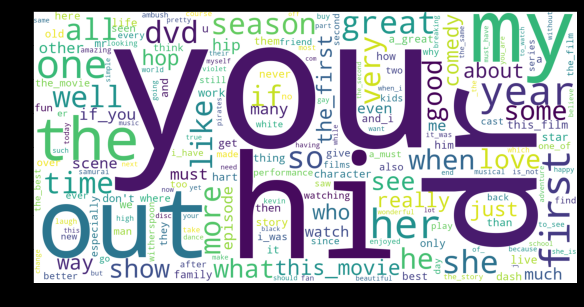

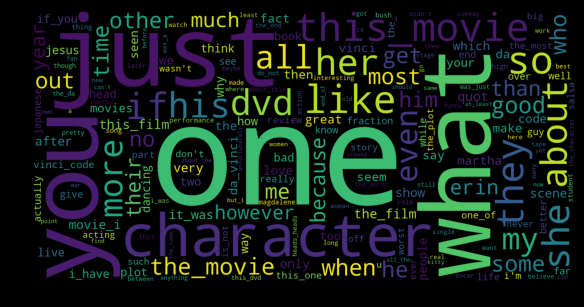

In [7]:
pos_vocab_dvd_pt = get_corpus(dvd_D_pt[0:50])
neg_vocab_dvd_pt = get_corpus(dvd_D_pt[50:])
stopwords = set(["num","i","movie","was","not","film"])
wordcloud = WordCloud(collocations=False, background_color="white",width=1600, height=800, stopwords=stopwords)
wordcloud.generate(' '.join(pos_vocab_dvd_pt))
plt.figure( figsize=(10,5), facecolor='k')
plt.imshow(wordcloud)
wordcloud = WordCloud(collocations=False, background_color="black",width=1600, height=800, stopwords=stopwords)
wordcloud.generate(' '.join(neg_vocab_dvd_pt))
plt.figure( figsize=(10,5), facecolor='k')
plt.imshow(wordcloud)

### Domain: electronics

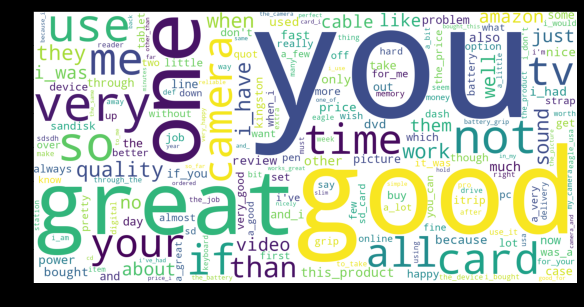

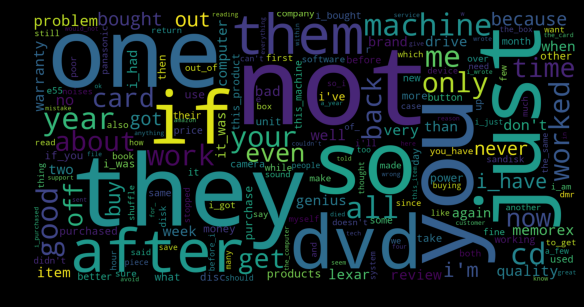

In [8]:
pos_vocab_elec_pt = get_corpus(elec_D_pt[0:50])
neg_vocab_elec_pt = get_corpus(elec_D_pt[50:])
stopwords = set(["i","num","my","was","product"])
wordcloud = WordCloud(collocations=False, background_color="white",width=1600, height=800, stopwords=stopwords)
wordcloud.generate(' '.join(pos_vocab_elec_pt))
plt.figure( figsize=(10,5), facecolor='k')
plt.imshow(wordcloud)
wordcloud = WordCloud(collocations=False, background_color="black",width=1600, height=800, stopwords=stopwords)
wordcloud.generate(' '.join(neg_vocab_elec_pt))
plt.figure( figsize=(10,5), facecolor='k')
plt.imshow(wordcloud)

### Domain: kitchen

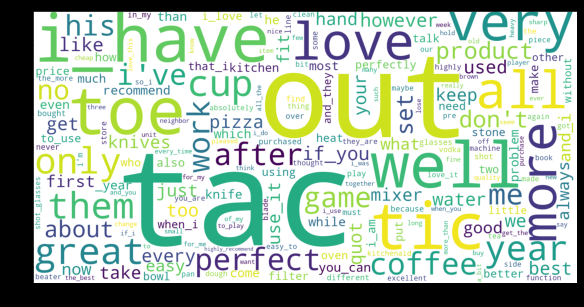

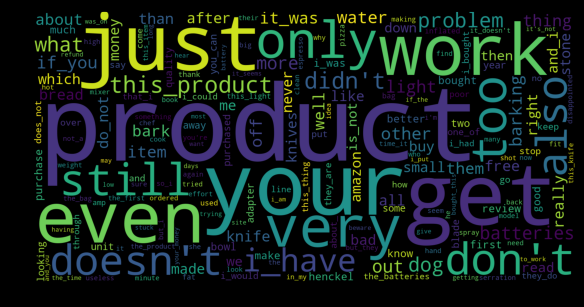

In [9]:
pos_vocab_kitchen_pt = get_corpus(kit_D_pt[0:50])
neg_vocab_kitchen_pt = get_corpus(kit_D_pt[50:])
stopwords = set(["i","num","my","you","was","not","if","they","time","so","one","use","when"])
wordcloud = WordCloud(collocations=False, background_color="white",width=1600, height=800, stopwords=stopwords)
wordcloud.generate(' '.join(pos_vocab_kitchen_pt))
plt.figure( figsize=(10,5), facecolor='k')
plt.imshow(wordcloud)
wordcloud = WordCloud(collocations=False, background_color="black",width=1600, height=800, stopwords=stopwords)
wordcloud.generate(' '.join(neg_vocab_kitchen_pt))
plt.figure( figsize=(10,5), facecolor='k')
plt.imshow(wordcloud)

## Learning curve of model

In [10]:
def get_gen_bound_vs_n_feat(dataset, feature_extractor, model, n_trials):
    
    avg_cv_error = 0
    avg_train_error = 0
    for trial in np.arange(0,n_trials):

        cv_error = 0
        train_error = 0
        cv_idx = stratified_split(dataset, 5)
        for n in np.arange(0,len(cv_idx)):

            val = []
            train = []

            val_idx = cv_idx[n]
            for idx in val_idx:
                val.append(dataset[idx])

            l = list(range(0,len(cv_idx)))
            train_idx = [x for x in l if x != n]
            for num in train_idx:
                for idx in list(cv_idx[num]):
                    train.append(dataset[idx])
            
            fe = feature_extractor.fit(get_corpus(train))
            X_train, y_train = get_Xy(train, fe)
            X_test, y_test = get_Xy(val, fe)
            
            clf = model.fit(X_train, y_train)
            
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)
            
            train_error += (1-train_score)/len(cv_idx)
            cv_error += (1-test_score)/len(cv_idx)

        avg_cv_error += cv_error/n_trials
        avg_train_error += train_error/n_trials

    return avg_cv_error, avg_train_error

In [13]:
test_2 = []
train_2 = []
dataset = books_D_train
num_feats_2 = np.arange(10,1000,25)
for n_feat in num_feats_2:
    print(n_feat)
    vocab = get_vocab(dataset, int(n_feat/2))
    avg_cv_error, avg_train_err = get_gen_bound_vs_n_feat(dataset,TfidfVectorizer(vocabulary=vocab),SGDClassifier(),1)
    test_2.append(avg_cv_error)
    train_2.append(avg_train_err)


10
35
60
85
110
135
160
185
210
235
260
285
310
335
360
385
410
435
460
485
510
535
560
585
610
635
660
685
710
735
760
785
810
835
860
885
910
935
960
985


In [ ]:
figure(figsize=(8, 6), dpi=80)

plt.plot(num_feats_2,test_2,'r-o',label='val')
plt.plot(num_feats_2,train_2,'b-o',label='train')

plt.xlabel("Num of features")
plt.ylabel("Avg CV Score on train/val set (%)")
plt.legend(loc="best")
plt.grid()
plt.title("Learning Curve")

### Note about learning curve

In the above learning curve, we notice that both train and validation errors reduce as the number of features increases, but a large gap remains between the errors. The validation error does not increase (even if number of features increased to 144000, but it is not shown here), as is normally observed in the case of over- fitting. The article in [3] explained that this phenomenon is that of a “unrepresentative train set”, where the information in the train set is limited, and cannot further improve the performance of the model on unseen data. But it doesn’t worsen the performance of the model on unseen data either.

When training a linear classifier on a text dataset, it learns all the vocabulary in the train set. And if the test set’s vocabulary and labels have similar distribution to that in the train set, the classifier is likely to generalize well. This is why in Figure 4, even when the train error is very close to 0, the validation error does not increase (in other ML systems, usually it does). The classifier has memorized the vocabulary in the train set, but the test set has a similar vocabulary distribution, so the classifier does relatively well (80% accuracy). 

### VC Dimension Analysis & Feature Dimensionality Reduction

All the candidate models I am using are binary linear classifiers, which means that their VC dimension is (k + 1), where k is the dimension of input data.

This poses a problem in this project because the dimensionality of the feature space is very high. Since the dataset uses the unigram/bigram representation, the number of features (words in the vocabulary) grows very quickly with the number of reviews in the corpus.

In the books domain train set, D_books_train, there are only 1500 data points but close train
to 144000 features. **This means that any linear classifier used on this dataset would be able to get a training accuracy of 100%, i.e. it shatters the 1500 data points, no matter what labels they have. Refer to [2] to learn about shattering.** So the classifier will not truly learn the trend in the data; it will memorize the training dataset.

The authors in [4] reported in-domain accuracies of about 80.4% for the books domain (see Figure 1 in [4]), and seem to have selected 1000 most informative features in each domain. In the paper, it is not clearly stated what method was used to select these 1000 features.

Therefore, my final decision is to use the discriminative feature selection method (see function definitions) and downsize the dataset to 1000 features, due to the following justifications:

- The validation error is still on the downward trend at 1000 features.
- The gap between the train and validation error is about 0.18 at 1000 features, which is reasonable.
- The authors in [4] used 1000 features.
- Number of features 1000 is less than the number of data points 1500 in train set.

### Baseline rule-based classification system for SL

The candidate models we will try later on are expected to perform better than this simple baseline. The baseline serves as a comparison to ensure that the ML models are truly doing better than simplistic models.

In [16]:
def word_rule(word, mult):
    score = 0
    pos_words = ["good","great", "like", "love", "excellent", "best","novel","his","her","hi","you","dr","very","one","so","out","tac","have"]
    neg_words = ["worst", "hate", "dislike", "bad", "terrible", "horrible", "about", "if", "diet", "one", "just", "what", "they" ,"not","you","get","your","product"]
    if word in pos_words:
        score = score + mult
    elif (word in neg_words):
        score = score - mult
    return score

In [17]:
def rule_based_classifier(dataset):
    pred_labels = []
    n = len(dataset)
    
    for i in range(0,n):
        review = dataset[i].split(" ")[0:-1]
        score = 0
        for word_score in review:
            words = word_score.split(":")[0].split("_")
            mult = int(word_score.split(":")[1])
            for word in words:
                score = score + word_rule(word, mult)
        pred_label = int(score>0)
        pred_labels.append(pred_label)
        
    true_labels = get_labels(dataset)
    score = np.sum(np.array(true_labels)==np.array(pred_labels))/len(pred_labels)
    CM = confusion_matrix(true_labels, pred_labels)
    return score, CM

In [18]:
books_base_score, books_base_CM = rule_based_classifier(books_D_val)
dvd_base_score, dvd_base_CM = rule_based_classifier(dvd_D_val)
kit_base_score, kit_base_CM = rule_based_classifier(kit_D_val)
elec_base_score, elec_base_CM = rule_based_classifier(elec_D_val)

print("Baseline system: rule-based classification:\n")
print("Score on books domain: ", np.round(books_base_score*100,2), "%")
print("Score on dvd domain: ", np.round(dvd_base_score*100,2), "%")
print("Score on kitchen domain: ", np.round(kit_base_score*100,2), "%")
print("Score on electronics domain: ", np.round(elec_base_score*100,2), "%")

Baseline system: rule-based classification:

Score on books domain:  56.5 %
Score on dvd domain:  59.5 %
Score on kitchen domain:  65.0 %
Score on electronics domain:  68.5 %


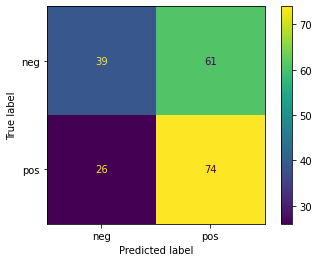

In [19]:
ConfusionMatrixDisplay(confusion_matrix=books_base_CM, display_labels=["neg","pos"]).plot()

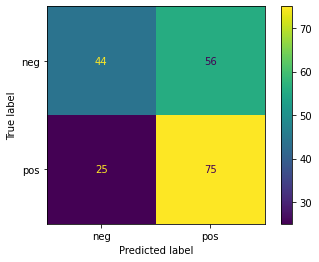

In [20]:
ConfusionMatrixDisplay(confusion_matrix=dvd_base_CM, display_labels=["neg","pos"]).plot()

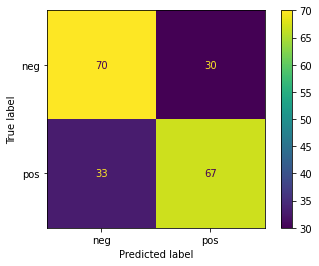

In [21]:
ConfusionMatrixDisplay(confusion_matrix=elec_base_CM, display_labels=["neg","pos"]).plot()

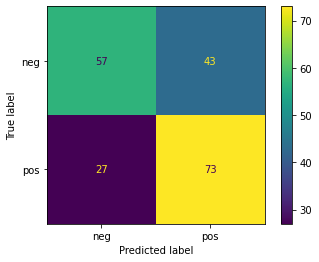

In [22]:
ConfusionMatrixDisplay(confusion_matrix=kit_base_CM, display_labels=["neg","pos"]).plot()

Text(0.5, 0, 'Domain')

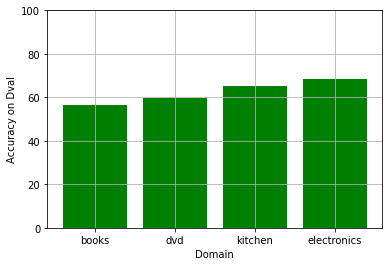

In [23]:
x = ['books','dvd','kitchen','electronics']
plt.bar(x, 100*np.array([books_base_score,dvd_base_score,kit_base_score,elec_base_score]), color='green')
plt.ylim(0, 100)
plt.grid()
plt.ylabel("Accuracy on Dval")
plt.xlabel("Domain")

### Multi-fold cross validation for model selection

### Domain: books

In [24]:
score_vec_books, var_books = try_models_on(books_D_train,"books",1)

DOMAIN: books 

Trying Model 1: Count Vectorizer & Logistic Regression, SCORE = 79.0%

Trying Model 2: TFIDF Vectorizer & Logistic Regression, SCORE = 78.6%

Trying Model 3: Count Vectorizer & Linear SVM, SCORE = 74.27%

Trying Model 4: TFIDF Vectorizer & Linear SVM, SCORE = 76.13%

Trying Model 5: Count Vectorizer & Gaussian NB, SCORE = 72.07%

Trying Model 6: TFIDF Vectorizer & Gaussian NB, SCORE = 72.73%

Trying Model 7: Count Vectorizer & SGD (Huber Loss), SCORE = 68.6%

Trying Model 8: TFIDF Vectorizer & SGD (Huber Loss), SCORE = 76.33%

Optimal model was Model 1


### Domain: dvd

In [25]:
score_vec_dvd, var_dvd = try_models_on(dvd_D_train,"dvd",1)

DOMAIN: dvd 

Trying Model 1: Count Vectorizer & Logistic Regression, SCORE = 76.67%

Trying Model 2: TFIDF Vectorizer & Logistic Regression, SCORE = 78.53%

Trying Model 3: Count Vectorizer & Linear SVM, SCORE = 73.73%

Trying Model 4: TFIDF Vectorizer & Linear SVM, SCORE = 73.87%

Trying Model 5: Count Vectorizer & Gaussian NB, SCORE = 65.47%

Trying Model 6: TFIDF Vectorizer & Gaussian NB, SCORE = 71.07%

Trying Model 7: Count Vectorizer & SGD (Huber Loss), SCORE = 66.4%

Trying Model 8: TFIDF Vectorizer & SGD (Huber Loss), SCORE = 73.33%

Optimal model was Model 2


### Domain: electronics

In [26]:
score_vec_elec, var_elec = try_models_on(elec_D_train,"electronics",1)

DOMAIN: electronics 

Trying Model 1: Count Vectorizer & Logistic Regression, SCORE = 78.87%

Trying Model 2: TFIDF Vectorizer & Logistic Regression, SCORE = 80.87%

Trying Model 3: Count Vectorizer & Linear SVM, SCORE = 75.6%

Trying Model 4: TFIDF Vectorizer & Linear SVM, SCORE = 76.53%

Trying Model 5: Count Vectorizer & Gaussian NB, SCORE = 77.53%

Trying Model 6: TFIDF Vectorizer & Gaussian NB, SCORE = 77.0%

Trying Model 7: Count Vectorizer & SGD (Huber Loss), SCORE = 70.33%

Trying Model 8: TFIDF Vectorizer & SGD (Huber Loss), SCORE = 78.13%

Optimal model was Model 2


### Domain: kitchen

In [27]:
score_vec_kit, var_kit = try_models_on(kit_D_train,"kitchen",1)

DOMAIN: kitchen 

Trying Model 1: Count Vectorizer & Logistic Regression, SCORE = 83.4%

Trying Model 2: TFIDF Vectorizer & Logistic Regression, SCORE = 84.4%

Trying Model 3: Count Vectorizer & Linear SVM, SCORE = 79.2%

Trying Model 4: TFIDF Vectorizer & Linear SVM, SCORE = 80.53%

Trying Model 5: Count Vectorizer & Gaussian NB, SCORE = 80.33%

Trying Model 6: TFIDF Vectorizer & Gaussian NB, SCORE = 80.27%

Trying Model 7: Count Vectorizer & SGD (Huber Loss), SCORE = 70.33%

Trying Model 8: TFIDF Vectorizer & SGD (Huber Loss), SCORE = 81.53%

Optimal model was Model 2


### Plot multi-fold CV errors on different domains for different models

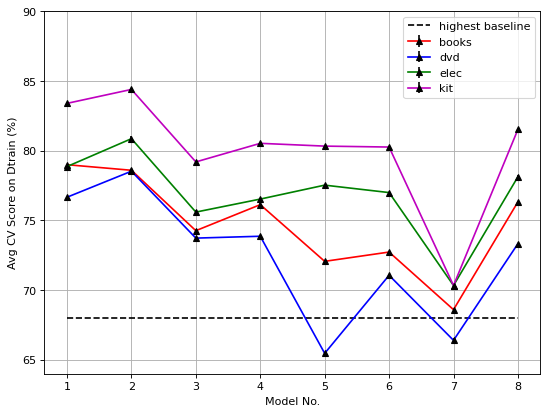

In [63]:
model_idx = np.arange(1,9)
figure(figsize=(8, 6), dpi=80)

#plt.plot(model_idx,score_vec_books,'r-o',label='books')
# plt.plot(model_idx,score_vec_dvd,'b-o',label='dvd')
# plt.plot(model_idx,score_vec_elec,'g-o',label='electronics')
# plt.plot(model_idx,score_vec_kit,'k-o',label='kitchen')
plt.plot(model_idx,np.ones(model_idx.shape)*68,'k--', label='highest baseline')

plt.errorbar(model_idx, score_vec_books, 100*np.array(var_books), label='books', linestyle='-',marker='^',color="r", ecolor='k',mfc='k',mec='k')
plt.errorbar(model_idx, score_vec_dvd, 100*np.array(var_dvd), label='dvd', linestyle='-',marker='^',color="b", ecolor='k',mfc='k',mec='k')
plt.errorbar(model_idx, score_vec_elec, 100*np.array(var_elec), label='elec', linestyle='-',marker='^',color="g", ecolor='k',mfc='k',mec='k')
plt.errorbar(model_idx, score_vec_kit, 100*np.array(var_kit), label='kit', linestyle='-',marker='^',color="m", ecolor='k',mfc='k',mec='k')

plt.xlabel("Model No.")
plt.ylabel("Avg CV Score on Dtrain (%)")
plt.legend(loc="best")
plt.grid()
plt.ylim([64,90])
plt.show()

## Train final model and get scores

In [31]:
def evaluate_final_model(train,val,test,domain_name,feature_extractor,model):
        
    # train
    feature_extractor.vocabulary = get_vocab(train, 500)
    X_train = np.array(feature_extractor.fit_transform(get_corpus(train)).todense())
    y_train = np.array(get_labels(train))
    clf = model.fit(X_train, y_train)
    
    # test on Dval
    X_val = np.array(feature_extractor.transform(get_corpus(val)).todense())
    y_val = np.array(get_labels(val))
    val_score = clf.score(X_val, y_val)
    CM = confusion_matrix(y_val, clf.predict(X_val))
    
    # test on Dtest
    X_test = np.array(feature_extractor.transform(get_corpus(test)).todense())
    y_test = np.array(get_labels(test))
    test_score = clf.score(X_test, y_test)
    
    delta = 0.05
    a = 1/(2*len(val))
    b = np.log(2/delta)
    val_bound = (1-val_score) + np.sqrt(a*b)
    
    delta = 0.05
    a = 1/(2*len(test))
    b = np.log(2/delta)
    test_bound = (1-test_score) + np.sqrt(a*b)
    
    return val_score, test_score, CM, val_bound, test_bound, clf

In [32]:
books_val_score, books_test_score, books_val_CM, books_val_bound, books_test_bound, books_trained_model = evaluate_final_model(books_D_train, books_D_val, books_D_test, "books", TfidfVectorizer(), LogisticRegression())
dvd_val_score, dvd_test_score, dvd_val_CM, dvd_val_bound, dvd_test_bound, dvd_trained_model = evaluate_final_model(dvd_D_train, dvd_D_val, dvd_D_test, "dvd", TfidfVectorizer(), LogisticRegression())
elec_val_score, elec_test_score, elec_val_CM, elec_val_bound, elec_test_bound, elec_trained_model = evaluate_final_model(elec_D_train, elec_D_val, elec_D_test, "elec", TfidfVectorizer(), LogisticRegression())
kit_val_score, kit_test_score, kit_val_CM, kit_val_bound, kit_test_bound, kit_trained_model = evaluate_final_model(kit_D_train, kit_D_val, kit_D_test, "kit", TfidfVectorizer(), LogisticRegression())



## Pickle models and save

In [33]:
pickle.dump(books_trained_model, open('books.pkl', 'wb'))

In [34]:
pickle.dump(dvd_trained_model, open('dvd.pkl', 'wb'))

In [35]:
pickle.dump(elec_trained_model, open('elec.pkl', 'wb'))

In [36]:
pickle.dump(kit_trained_model, open('kit.pkl', 'wb'))

### Generalization bounds on E_val

In [60]:
print("Eval:",1-np.array([books_val_score, dvd_val_score, elec_val_score, kit_val_score]))
print("Generalization bounds:", books_val_bound,dvd_val_bound,elec_val_bound,kit_val_bound)
print("Etest:",1-np.array([books_test_score, dvd_test_score, elec_test_score, kit_test_score]))

Eval: [0.23  0.195 0.15  0.18 ]
Generalization bounds: 0.32603227913199206 0.29103227913199203 0.2460322791319921 0.27603227913199213
Etest: [0.195 0.2   0.14  0.165]


Model is trained successfully. The $E_{test}$ values are lesser than the generalization bounds for each domain.

## Plot scores of final model vs baselines and other results

In [38]:
base_scores = 100*np.array([books_base_score,dvd_base_score,kit_base_score,elec_base_score])

In [39]:
with open('baseline.npy', 'wb') as f:
    np.save(f, base_scores)

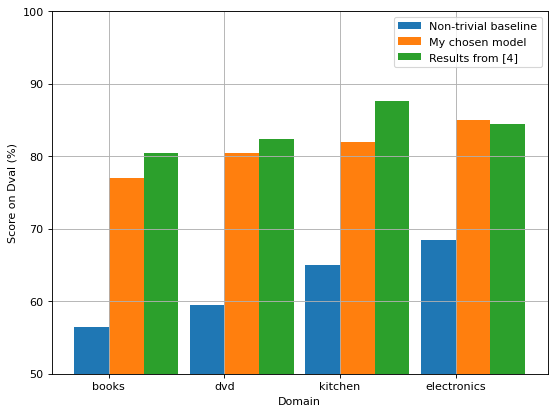

In [61]:
width = 0.3
figure(figsize=(8, 6), dpi=80)
ind = np.arange(4)
model1 = 100*np.array([books_base_score,dvd_base_score,kit_base_score,elec_base_score])
model2 = 100*np.array([books_val_score,dvd_val_score,kit_val_score,elec_val_score])
model3 = [80.4,82.4,87.7,84.4]
plt.bar(ind, model1, width, label='Non-trivial baseline')
plt.bar(ind + width, model2, width, label='My chosen model')
plt.bar(ind + 2*width, model3, width, label='Results from [4]')
plt.ylim([50,100])
plt.ylabel('Score on Dval (%)')
plt.xlabel('Domain')
plt.xticks(ind + width / 2, ('books', 'dvd', 'kitchen', 'electronics'))
plt.legend(loc='best')
plt.grid()
plt.show()

### Plot confusion matrices for final model

#### Domain: books

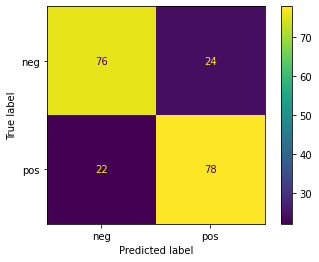

In [41]:
ConfusionMatrixDisplay(confusion_matrix=books_val_CM, display_labels=["neg","pos"]).plot()

#### Domain: dvd

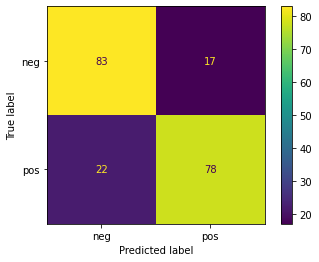

In [42]:
ConfusionMatrixDisplay(confusion_matrix=dvd_val_CM, display_labels=["neg","pos"]).plot()

#### Domain: electronics

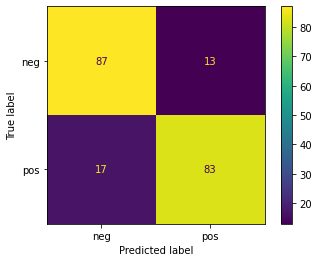

In [43]:
ConfusionMatrixDisplay(confusion_matrix=elec_val_CM, display_labels=["neg","pos"]).plot()

#### Domain: kitchen

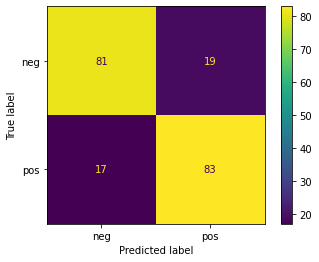

In [44]:
ConfusionMatrixDisplay(confusion_matrix=kit_val_CM, display_labels=["neg","pos"]).plot()

-------

## References

[1] Y. Abu-Mostafa, M. Magdon-Ismail and H. Lin, Learning from data. [Estados Unidos]: AMLBook, 2012, Chapter 5 (Three Learning Principles).

[2] Y. Abu-Mostafa, M. Magdon-Ismail and H. Lin, Learning from data. [Estados Unidos]: AMLBook, 2012, Chapter 2 (Training versus Testing)

[3] https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

[4] J. Blitzer, M. Dredze, and F. Pereira, “Biographies, bollywood, boomboxes and blenders: Domain adaptation for sentiment classification,” in Proceedings of the 45th Annual Meeting of the Association of Computational Linguistics, Prague, Czech Republic, 2007, pp. 432–439.

